## Data Exploration

### IMPORTS

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras

In [2]:
os.getcwd()

'C:\\Users\\chava\\Desktop\\MLRobotics\\PROJECT1'

In [72]:
##  VARIABLES
## FILES
INPUT_FOLDER = 'input'
IMAGES_ACESS = 'images/*.jpg'
INFO_PATIENTS = 'HAM10000_metadata.csv'
PIXEL_28_RGB_CSV = 'hmnist_28_28_RGB.csv'

#data COLUMNS
LESION_ID = 'lesion_id'
IMAGE_ID = 'image_id'
DX = 'dx'
DX_TYPE = 'dx_type'
AGE = 'age'
SEX = 'sex'
LOCALIZATION = 'localization'
PATH = 'path'

#OTHER VARIABLES
MALE = 'male'
FEMALE = 'female'
UNKNOWN = 'unknown'
SCALP = 'scalp'
EAR = 'ear'
FACE = 'face'
BACK = 'back'
TRUNK = 'trunk'
CHEST = 'chest'
UPPER_EXTREMEMITY = 'upper_extremity'
ABDOMEN = 'abdomen'
LOWER_EXTREMITY = 'lower_extremity'
GENITAL = 'genital'
NECK = 'neck'
HAND = 'hand'
FOOT = 'foot'
ACRAL = 'acral'
BKL = 'bkl'
NV = 'nv'
DF = 'df'
MEL = 'mel'
VASC = 'vasc'
BCC = 'bcc'
AKIEC = 'akiec'
DICT_TARGETS = (
    'akiec' ,
    'bcc' ,
    'bkl' ,
    'df' ,
    'mel' ,
    'nv',
    'vasc'
)

WIDTH = 128
HEIGHT = 128
CHANNELS = 3

VALIDATION_SPLIT = 0.15 # 15%
TEST_SPLIT = 0.2353 # 20%
RANDOM_STATE = 0

STANDARDIZE_AXIS_CHANNELS = (0,1,2)
NUMBER_CLASSES = 7

class_sampling2={
    0: 213,  # akiec
    1: 334,  # bcc
    2: 714,  # bkl
    3: 75,  # df
    4: 723,  # mel # Try to make the model more sensitive to Melanoma.
    5: 500,  # nv
    6: 92,  # vasc
}

class_sampling={ # oversampling
    0: 2179, # akiec
    1: 2179, # bcc
    2: 2179, # bkl
    3: 2179, # df
    4: 2179, # mel # Try to make the model more sensitive to Melanoma.
    5: 4358, # nv
    6: 2179, # vasc
}

HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
WIDTH_SHIFT_RANGE = 0.1
HEIGHT_SHIFT_RANGE = 0.1
ROTATION_RANGE = 10
ZOOM_RANGE = 0.25
BRITNESS_RANGE= 0.3

In [4]:
## IMPORTANT PATH FOLDERS, THAT AGGREGATES DATASET INFORMATION
ROOT_DIR = os.getcwd()
print(ROOT_DIR)
INPUT_DIR = os.path.join(ROOT_DIR, INPUT_FOLDER)
print(INPUT_DIR)
PATIENTS_INFO = os.path.join(INPUT_DIR,INFO_PATIENTS)
print(PATIENTS_INFO)


C:\Users\chava\Desktop\MLRobotics\PROJECT1
C:\Users\chava\Desktop\MLRobotics\PROJECT1\input
C:\Users\chava\Desktop\MLRobotics\PROJECT1\input\HAM10000_metadata.csv


In [5]:
def getImages(directory):

    '''
    THIS FUNTION RETRIEVES ALL IMAGES FILES
    :param directory: str --> dict/*.jpg
    :return: list of all jpg files
    '''

    try:

        return sorted(glob.glob(directory))

    except:
        raise

In [6]:
## GET PATHS FOR ALL IMAGES
IMAGES_REGEX = os.path.join(INPUT_DIR, IMAGES_ACESS)
images_paths = getImages(IMAGES_REGEX)
images_paths[0]
len(images_paths)

10015

In [7]:
##GET DATA
data = pd.read_csv(PATIENTS_INFO)
data.iloc[0] #SEE OUTPUT OF FIRST ROW, TO CHECK AFTER IF NEW data IS ALREADY WELL CREATED
data.head(5)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
## data INFO
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [9]:
##SORT BY IMAGE_ID, IN COHERENCE IMAGE_PATHS
data = data.sort_values('image_id', ascending=True)
data.head(5)


,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest


In [10]:
def addNewColumn_Populate_data(data, name_new_column, dataToPopulate):

    
    '''
    THIS FUNCTION IS USED TO ADD NEW COLUMN TO data, AND POPULATE COLUMN WITH DATA
    :param data: data --> data to apply changes
    :param name_new_column: str --> name of new column
    :param dataToPopulate: List (str) --> strings to populate data
    :return: data changed
    '''

    try:

        data[name_new_column] = dataToPopulate
        return data

    except:
        raise


In [11]:
## SET NEW COLUMN TO data AND IMAGE PATH TO SORTED data (SAME ORDER data AND LIST OF IMAGE_PATHS) 
data = addNewColumn_Populate_data(data, 'path', images_paths)
data = data.sort_index() #sort by index again
data.head(5)


,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...


In [12]:
## COUNT HOW MANY IMAGES ARE INTO DATASET
data.shape[0]


10015

In [13]:
## GET COLUMNS NAMES
data.columns


Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path'],
      dtype='object')

In [14]:
## CHECK HOW MANY CLASSES EXIST
classes = data.dx.unique()
classes

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [15]:
## CHECK NULL VALUES BY COLUMN
data.isnull().sum()


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
dtype: int64

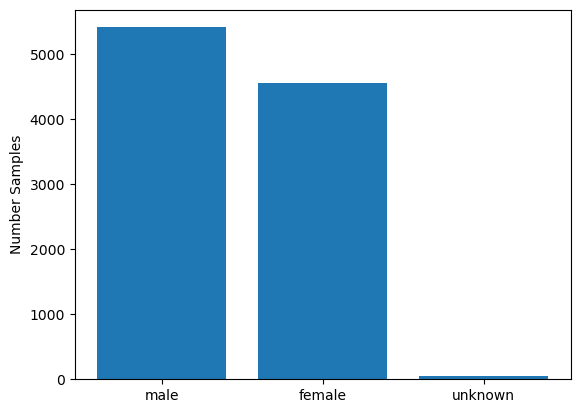

In [16]:
## HISTOGRAM WITH SEX DISTRIBUTION
bar_names = data.sex.unique()
y_pos = np.arange(len(bar_names))
samples_total = [data.loc[data.sex == MALE, SEX].count(), 
                 data.loc[data.sex == FEMALE, SEX].count(),
                 data.loc[data.sex == UNKNOWN, SEX].count()]
plt.bar(y_pos, samples_total, align='center')
plt.xticks(y_pos, bar_names)
plt.ylabel('Number Samples')
plt.show()


In [17]:
## HISTOGRAM WITH LOCALIZATION DISTRIBUTION
local_occurences = data.localization.unique()
local_occurences

array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

In [18]:
## DESCRIPTION OF AGE
data[AGE].describe()


count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64

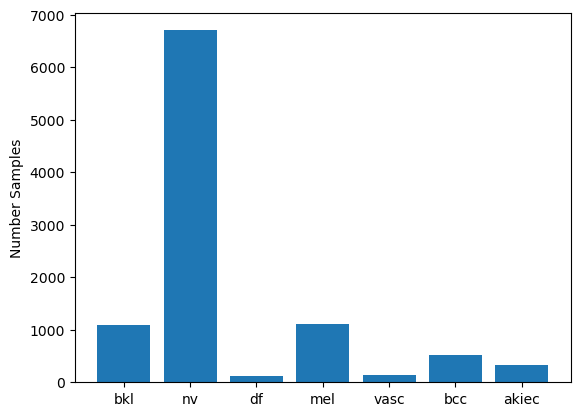

In [19]:
## DISTRIBUTION NUMBER EXAMPLES PER CLASS
y_pos = np.arange(len(classes))
title_classes = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']
samples_total = [data.loc[data.dx == BKL, DX].count(), 
                 data.loc[data.dx == NV, DX].count(),
                 data.loc[data.dx == DF, DX].count(),
                 data.loc[data.dx == MEL, DX].count(),
                 data.loc[data.dx == VASC, DX].count(),
                 data.loc[data.dx == BCC, DX].count(),
                 data.loc[data.dx == AKIEC, DX].count()]
plt.bar(y_pos, samples_total, align='center')
plt.xticks(y_pos, title_classes)
plt.ylabel('Number Samples')
plt.show()


<Axes: xlabel='dx_type'>

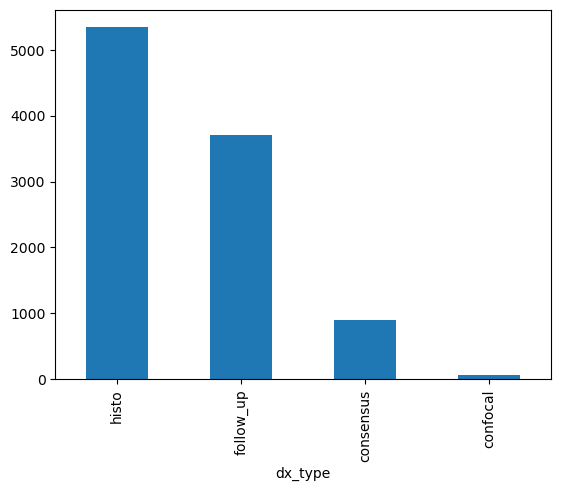

In [20]:
## CHECK TYPE OF DIAGNOSIS MADED
data[DX_TYPE].value_counts().plot(kind='bar')


array([[<Axes: title={'center': 'akiec'}>,
        <Axes: title={'center': 'bcc'}>, <Axes: title={'center': 'bkl'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'mel'}>,
        <Axes: title={'center': 'nv'}>],
       [<Axes: title={'center': 'vasc'}>, <Axes: >, <Axes: >]],
      dtype=object)

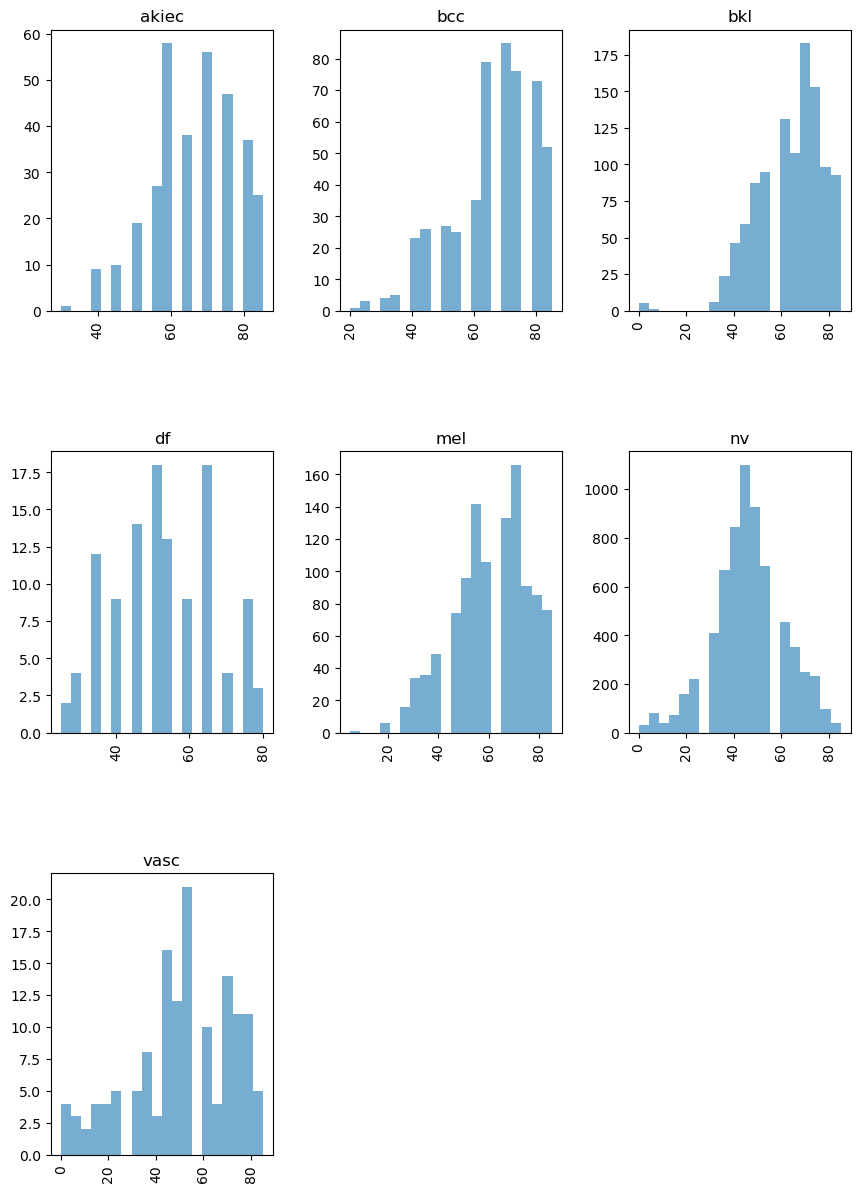

In [21]:
## CHECK DISTRIBUTION OF CLASSES BY AGE
data[AGE].hist(by=data[DX], bins=20, alpha=0.6, figsize=(10, 15))


array([[<Axes: title={'center': 'akiec'}>,
        <Axes: title={'center': 'bcc'}>, <Axes: title={'center': 'bkl'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'mel'}>,
        <Axes: title={'center': 'nv'}>],
       [<Axes: title={'center': 'vasc'}>, <Axes: >, <Axes: >]],
      dtype=object)

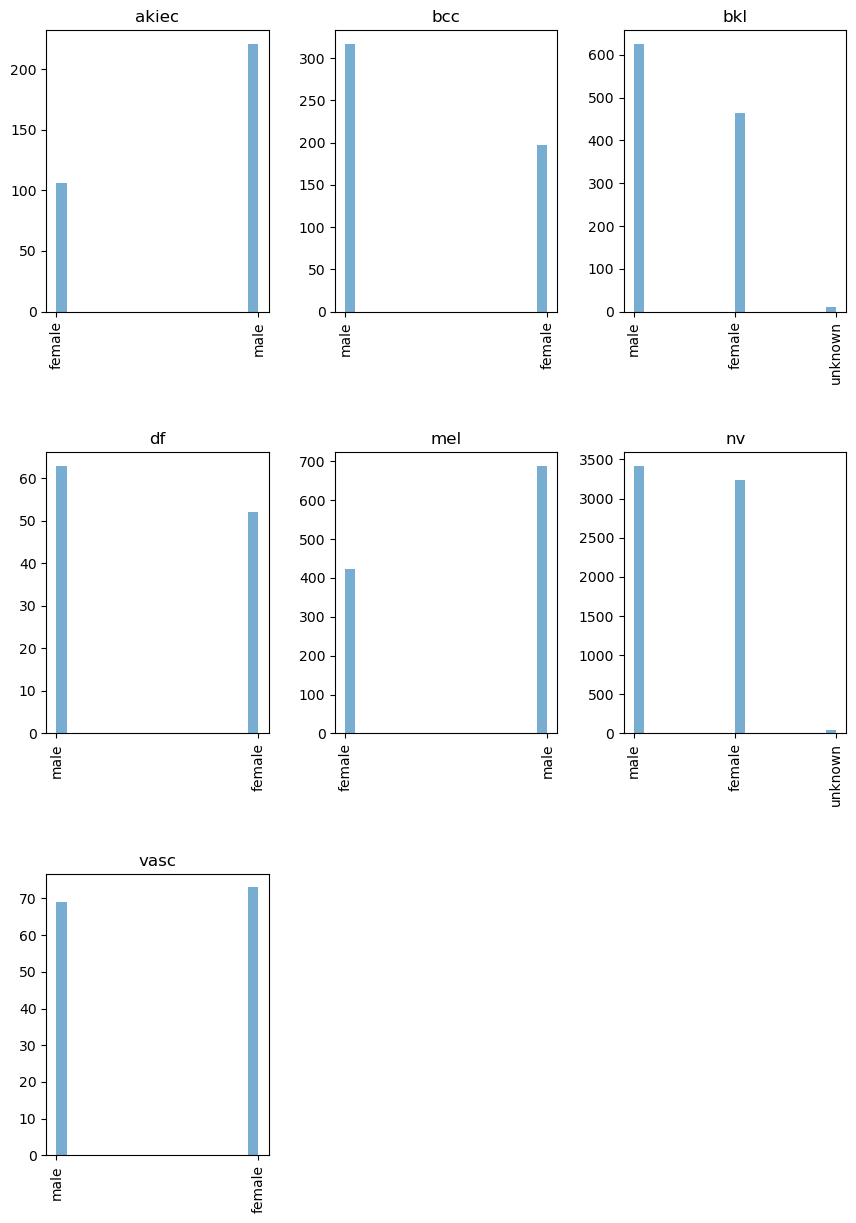

In [22]:
## CHECK DISTRIBUTION OF CLASSES BY SEX
data[SEX].hist(by=data[DX], bins=20, alpha=0.6, figsize=(10, 15))


<Axes: title={'center': 'Samples per localization'}, ylabel='localization'>

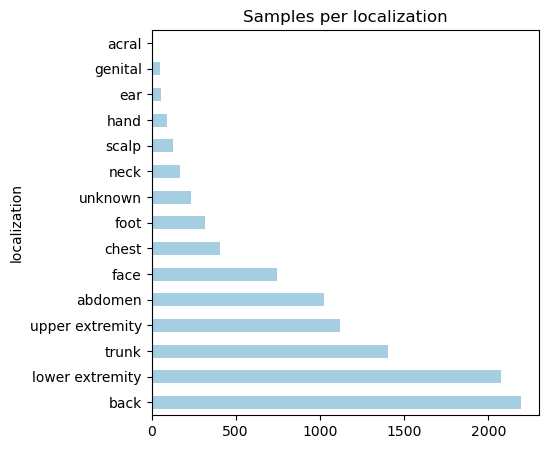

In [23]:
## CHECK WHAT ARE THE MOST BODY AFFECTED AREAS
data[LOCALIZATION].value_counts().plot(kind='barh', figsize=(5, 5), colormap='Paired',
                                        title='Samples per localization')


array([[<Axes: title={'center': 'akiec'}>,
        <Axes: title={'center': 'bcc'}>, <Axes: title={'center': 'bkl'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'mel'}>,
        <Axes: title={'center': 'nv'}>],
       [<Axes: title={'center': 'vasc'}>, <Axes: >, <Axes: >]],
      dtype=object)

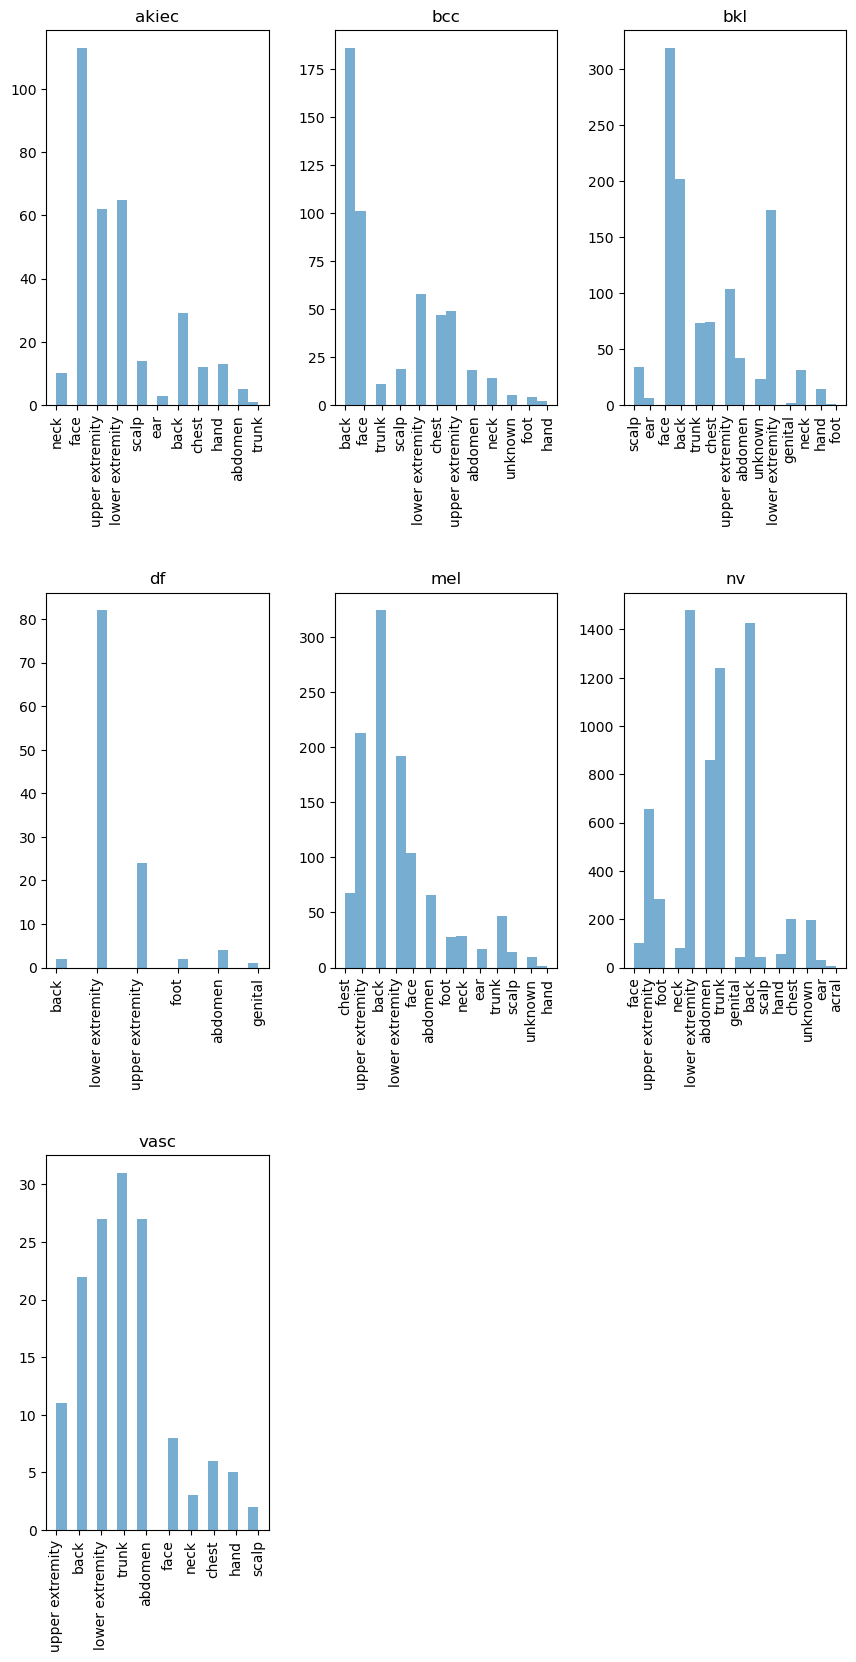

In [24]:
## AFFECTED BODY AREAS BY CLASS
data[LOCALIZATION].hist(by=data[DX], bins=20, alpha=0.6, figsize=(10, 20))


In [25]:
## ACESS IMAGE PIXELS data
PIXELS_PATH = os.path.join(INPUT_DIR, PIXEL_28_RGB_CSV)
pixel_data = pd.read_csv(PIXELS_PATH)


In [26]:
## CHECK SHAPE OF data
pixel_data.shape


(10015, 2353)

In [27]:
pixel_data['label'].value_counts()
# 0 - AKIEC, 1 - BCC, 2 - BKL, 3- DF, 4 - NV, 5 - VASC, 6 - MEL

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

In [28]:
## FIRST FIVE LINES OF data
pixel_data.head(5)


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [29]:
## SHUFFLE ROWS
## NO RESET INDEX, BECAUSE IT'S NOT IMPORTANT IN THIS ANALYSIS
pixel_data = pixel_data.sample(n=len(pixel_data), random_state=42)    
pixel_data.head(5)


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
1617,158,80,110,154,67,98,166,81,119,181,...,160,83,113,153,85,113,142,80,106,6
8128,214,167,173,215,165,169,217,166,167,218,...,219,151,151,217,148,141,214,147,140,4
2168,206,127,123,209,129,122,215,144,143,220,...,223,164,151,219,153,136,216,148,133,6
1090,205,152,161,210,156,166,214,159,168,214,...,199,157,159,197,154,157,194,152,155,2
7754,123,97,103,137,108,114,136,103,104,145,...,145,122,129,138,116,120,131,109,110,4


In [30]:
## EXAMPLE OF THREE IMAGES BY CLASSES --> USING 28*28 PIXEL RGB CSV DILE
def getImagesByClass(target, numberImages):
    images = []
    for i in range(pixel_data.shape[0]):
        if pixel_data.label.iat[i] == target:
            images.append(pixel_data.iloc[i, :-1].values)
        if len(images) == numberImages:
            break
    return images

images_by_classes = []
order = pixel_data.label.unique()
for i in range(len(order)):
    images_by_classes.append(getImagesByClass(i,3))
images_by_classes


[[array([155, 111, 116, ..., 110,  59,  70], dtype=int64),
  array([209, 185, 184, ..., 161, 140, 131], dtype=int64),
  array([202, 135, 160, ..., 192, 146, 157], dtype=int64)],
 [array([180, 148, 152, ..., 191, 157, 155], dtype=int64),
  array([56, 41, 31, ..., 10,  7,  7], dtype=int64),
  array([81, 54, 68, ...,  8,  4, 10], dtype=int64)],
 [array([205, 152, 161, ..., 194, 152, 155], dtype=int64),
  array([186, 144, 152, ..., 185, 149, 153], dtype=int64),
  array([154, 131, 139, ..., 169, 148, 149], dtype=int64)],
 [array([246, 191, 182, ..., 226, 180, 167], dtype=int64),
  array([194, 143, 153, ..., 184, 133, 131], dtype=int64),
  array([176, 145, 138, ..., 150, 111, 107], dtype=int64)],
 [array([214, 167, 173, ..., 214, 147, 140], dtype=int64),
  array([123,  97, 103, ..., 131, 109, 110], dtype=int64),
  array([185, 136, 113, ..., 211, 162, 143], dtype=int64)],
 [array([147, 118, 127, ...,  73,  56,  56], dtype=int64),
  array([187, 126, 119, ..., 193, 152, 169], dtype=int64),
  ar

In [31]:
## RESIZE DATA FROM (DIMENSIONS, ) TO (WIDTH, HEIGHT, CHANNELS)
images_by_classes = np.array(images_by_classes)
images_by_classes = np.reshape(images_by_classes, (images_by_classes.shape[0],
                                                   images_by_classes.shape[1],
                                                   28, 28, 3))

In [32]:
images_by_classes.shape


(7, 3, 28, 28, 3)

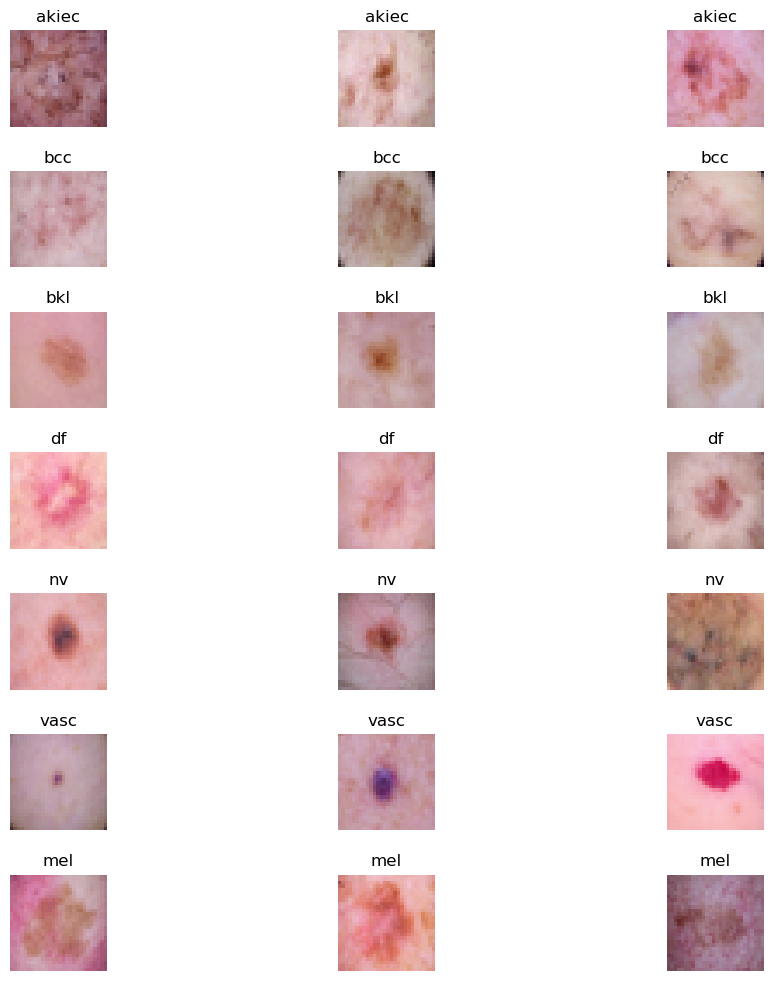

In [33]:
## PLOT 3 IMAGES BY EACH CLASS
f, axr = plt.subplots(7,3, figsize=(10,10))
f.tight_layout()
title = [AKIEC, BCC, BKL, DF, NV, VASC, MEL]
for i in range(7):
    for j in range(3):
        axr[i,j].set_axis_off()
        axr[i,j].imshow(images_by_classes[i][j])
        axr[i,j].set_title(title[i])
#plt.show()

In [34]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...


### Imputing AGE Column

In [35]:
import math

def impute_null_values(data, column, mean=True):
    series_column = data[column]

    if len(series_column) == 0:
        return data

    if mean:
        column_mean = series_column.mean()
        truncated_mean = math.trunc(column_mean)  # Truncate to integer
        data[column].fillna(truncated_mean, inplace=True)
    else:
        column_median = series_column.median()
        truncated_median = math.trunc(column_median)  # Truncate to integer
        data[column].fillna(truncated_median, inplace=True)

    return data


In [36]:
data = impute_null_values(data, AGE, mean=True)
data.head(5)



,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\chava\Desktop\MLRobotics\PROJECT1\inp...


In [37]:
data.isnull().sum()


lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
dtype: int64

In [38]:
## dx is a column with labels for categories, converting it to category will allow for efficient processing in classification tasks.
data.dx = data.dx.astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   lesion_id     10015 non-null  object  
 1   image_id      10015 non-null  object  
 2   dx            10015 non-null  category
 3   dx_type       10015 non-null  object  
 4   age           10015 non-null  float64 
 5   sex           10015 non-null  object  
 6   localization  10015 non-null  object  
 7   path          10015 non-null  object  
dtypes: category(1), float64(1), object(6)
memory usage: 636.1+ KB


## Getting Data Ready for the model

### Splitting Data

In [39]:
 d = dict(enumerate(data.dx.cat.categories))
d

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

In [40]:
numeric_targets = data.dx.cat.codes.values
numeric_targets

array([2, 2, 2, ..., 0, 0, 4], dtype=int8)

In [41]:
number_images = data.shape[0]
images_by_class = [int(round(((data.loc[data.dx == DICT_TARGETS[i], 'dx'].count()) / number_images)*10015))
                                   for i in range(len(data.dx.unique()))]
images_by_class

[3, 5, 11, 1, 11, 67, 1]

In [42]:
counter_by_class = [DICT_TARGETS[i] for i in range(len(data.dx.unique()))]
counter_by_class

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [43]:
def getDataFromImages(data, size):
    """
    This function retrieves X and Y data from all images.
    :param data: Pandas data with image paths and corresponding targets.
    :param size: int - Desired sample size, should be <= total images.
                 If size < total images, the function performs stratified sampling.
    :return: X: numpy array - Image data (pixels).
    :return: Y: numpy array - Targets for each image.
    """
    
    # Get total images count
    number_images = data.shape[0]
    X = []
    Y = []

    # Dictionary for mapping categories to numeric targets
    d = dict(enumerate(data.dx.cat.categories))
    numeric_targets = data.dx.cat.codes.values

    # Check if requested size exceeds the available number of images
    if size > number_images:
        raise ValueError("Requested size exceeds available images.")

    # Stratified sampling if size is less than the total number of images
    elif size < number_images:
        images_by_class = [int(round((data[data.dx == target].shape[0] / number_images) * size))
                           for target in data.dx.unique()]
        
        counter_by_class = [target for target in data.dx.unique()]
        for i in range(number_images):
            target = data.at[i, 'dx']  # Get target of the image
            index_target_counter = counter_by_class.index(target)
            
            # Check if allowed image count for this class is not zero
            if images_by_class[index_target_counter] > 0:
                X.append(getX_Y_Image(data.at[i, 'path']))
                Y.append(numeric_targets[i])
                images_by_class[index_target_counter] -= 1
            
            # Stop if all classes have reached their stratified sample size
            if all(count == 0 for count in images_by_class):
                break

        return np.array(X), np.array(Y)

    # If size equals the total number of images, return all images
    else:
        for i in range(number_images):
            X.append(getX_Y_Image(data.at[i, 'path']))
            Y.append(numeric_targets[i])

        return np.array(X), np.array(Y)


In [44]:
def getX_Y_Image(image_path: str):
    '''
    THIS FUNCTION IS USED TO RETRIEVE X (pixel RGB VALUES) of an image
    :param image_path: str --> image path of image
    :return: X: numpy array --> RGB VALUES OF IMAGE
    '''

    image = cv2.imread(image_path)
    X = cv2.resize(image, (HEIGHT, WIDTH), interpolation=cv2.INTER_CUBIC)

    return X


In [45]:
import cv2
X, Y = getDataFromImages(data=data, size=10015)
print(X.shape)
print(Y.shape)

(10015, 128, 128, 3)
(10015,)


In [46]:
indexes = np.arange(X.shape[0])
X_train, X_val, y_train, y_val, indeces_train, indices_val = train_test_split(X, Y, indexes, test_size=VALIDATION_SPLIT, shuffle=True,
                                                      random_state=RANDOM_STATE, stratify=Y)
indexes = indeces_train
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_train, y_train, indexes, test_size=TEST_SPLIT,
                                                        shuffle=True, random_state=RANDOM_STATE, stratify=y_train)


In [47]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(6509, 128, 128, 3)
(6509,)
(1503, 128, 128, 3)
(1503,)
(2003, 128, 128, 3)
(2003,)


### Normalizing the Data

In [48]:
def normalize(X_train, X_val, X_test):
    '''
    #REF https://forums.fast.ai/t/images-normalization/4058/8
    :param X_train: numpy array representing training data
    :param X_val: numpy array representing validation data
    :param X_test: numpy array representing test data
    :return X_train: numpy array normalized
    :return X_val: numpy array normalized
    :return X_test: numpy array normalized
    '''

    # Calculate the mean and standard deviation for normalization
    mean = np.mean(X_train, axis=STANDARDIZE_AXIS_CHANNELS)  # STANDARDIZE BY CHANNELS
    std = np.std(X_train, axis=STANDARDIZE_AXIS_CHANNELS)    # STANDARDIZE BY CHANNELS
    print(mean)
    print(std)

    # Normalize the datasets using the calculated mean and std
    X_train = (X_train - mean) / (std + 1e-7)
    X_val = (X_val - mean) / (std + 1e-7)
    X_test = (X_test - mean) / (std + 1e-7)

    # Transform float64 numpy arrays to float32 to reduce memory usage
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)


    return X_train, X_val, X_test


In [49]:
X_train, X_val, X_test = normalize(X_train, X_val, X_test)

[145.53616869 139.42013422 194.75952985]
[43.48181032 39.03734679 36.18688406]


In [50]:
def one_hot_encoding(y_train, y_val, y_test):
    '''
    :param y_train: numpy array with training targets
    :param y_val: numpy array with validation targets
    :param y_test: numpy array with test targets
    :return y_train: numpy array categorized [1 0] --> class 0 or [0 1] --> class 1
    :return y_val: numpy array categorized
    :return y_test: numpy array categorized
    '''
    y_train = keras.utils.to_categorical(y_train, NUMBER_CLASSES)
    y_val = keras.utils.to_categorical(y_val, NUMBER_CLASSES)
    y_test = keras.utils.to_categorical(y_test, NUMBER_CLASSES)
    return y_train, y_val, y_test


In [51]:
y_train, y_val, y_test = one_hot_encoding(y_train, y_val, y_test)

In [52]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.])

In [53]:
y_test[0]

array([0., 1., 0., 0., 0., 0., 0.])

### Strategies for sampling

In [54]:
import numpy as np
class Data:

    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test):
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test

    def decodeYData(self):
        '''
        THIS FUNCTION IS USED TO DISABLE ONE-HOT-ENCODING
        e.g --> y_train = [ [0 1] [1 0] ]
                return [ [1] [0] ]
        :return: numpy array: decoded training targets
        '''
        y_train = [np.argmax(self.y_train[i], axis=0) for i in range(self.y_train.shape[0])]
        y_train = np.array(y_train)
        return y_train

    def reshape4D_to_2D(self):
        '''
        THIS FUNCTION IS USED TO RESHAPE TRAINING DATA FROM 4D TO 2D --> IS NEED TO APPLY STRATEGIES
        :return: numpy array --> training data 2D (SAMPLES, FEATURES) --> FEATURES = (WIDTH * HEIGHT * CHANNELS)
        '''
        feature_reshape = (self.X_train.shape[1] * self.X_train.shape[2] * self.X_train.shape[3])
        X_train = self.X_train.reshape(self.X_train.shape[0], feature_reshape)
        return X_train

    def reshape2D_to_4D(self):
        '''
        THIS FUNCTION IS USED TO RESHAPE TRAINING DATA FROM 2D TO 4D --> IS NEED TO APPLY STRATEGIES
        :return: numpy array --> training data 4D  (SAMPLES, WIDTH, HEIGHT, CHANNELS)
        '''
        shape_data = (self.X_train.shape[0], WIDTH, HEIGHT, CHANNELS)
        X_train = self.X_train.reshape(shape_data)
        return X_train


In [60]:
data_obj = Data(X_train=X_train, X_val=X_val, X_test=X_test,
                         y_train=y_train, y_val=y_val, y_test=y_test)

In [56]:
from abc import ABC, abstractmethod

class Strategy(ABC):

    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def applyStrategy(self, data : Data, **kwargs):
        pass

#### Undersampling


In [66]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import keras
from sklearn.utils import shuffle

class UnderSampling(Strategy):

    def __init__(self):
        super(UnderSampling, self).__init__()

    def applyStrategy(self, data: Data, **kwargs):
        '''
        This function applies undersampling technique on training data.
        :param data: Data object containing training data and targets
        :return: Undersampled training data and targets
        '''
        # Convert targets to 1D array by finding the index of the highest probability
        numberValues = np.argmax(data.y_train, axis=1)
        occorrences_counter = np.bincount(numberValues)
        
        # Initialize undersampler with a defined strategy
        underSampler = RandomUnderSampler(random_state=0, sampling_strategy=class_sampling2)

        # Reshape training data for undersampling
        X_train = data.reshape4D_to_2D()
        decoded_ytrain = data.decodeYData()

        # Perform undersampling
        deepData = Data(data.X_train, None, None, None, None, None)
        deepData.X_train, decoded_ytrain = underSampler.fit_resample(X_train, decoded_ytrain)

        # Reshape back to 4D and clean up
        X_train = deepData.reshape2D_to_4D()
        del deepData

        # Convert back to categorical encoding
        decoded_ytrain = keras.utils.to_categorical(decoded_ytrain, NUMBER_CLASSES)

        # Shuffle data
        X_train, decoded_ytrain = shuffle(X_train, decoded_ytrain)
        
        return X_train, decoded_ytrain

#### OverSampling

In [ ]:
class OverSampling(Strategy):

    def __init__(self):
        super(OverSampling, self).__init__()

    def applyStrategy(self, data: Data, **kwargs):
        '''
        THIS FUNCTION APPLIES OVERSAMPLING TECHNIQUE ON TRAINING DATA
        :param data: Data.Data object containing training data and targets
        :return X_train: numpy array --> over sampled training data
        :return y_train: numpy array --> over sampled training targets
        '''

        # Check if kwargs is empty
        if not bool(kwargs) == False:  # CHECK IF DICT IS EMPTY
            raise CustomError.ErrorCreationModel(.ERROR_NO_ARGS_ACCEPTED)

        numberValues = [np.argmax(data.y_train, axis=1)]
        numberValues = np.array(numberValues)
        numberValues = numberValues.reshape(numberValues.shape[0] * numberValues.shape[1])
        occorrences_counter = np.bincount(numberValues)

        overSampler = RandomOverSampler(random_state=0, sampling_strategy=class_sampling)  # ALLOWS REPRODUCIBILITY

        # I NEED TO RESHAPE TRAINING DATA TO 2D ARRAY (SAMPLES, FEATURES)
        X_train = data.reshape4D_to_2D()

        # APPLY DECODE OF TARGET DATA NEEDED TO APPLY RESAMPLE
        decoded_ytrain = data.decodeYData()

        # APPLY RESAMPLE OF DATA
        args = (None, None, None, None, None)  # REDUCE MEMORY USAGE
        deepData = Data.Data(data.X_train, *args)
        deepData.X_train, decoded_ytrain = overSampler.fit_resample(X_train, decoded_ytrain)

        # I NEED TO RESHAPE DATA AGAIN FROM 2D TO 4D
        X_train = deepData.reshape2D_to_4D()
        del deepData

        occorrences_counter = np.bincount(decoded_ytrain)

        # TRANSFORM Y_DECODED TO CATEGORICAL AGAIN
        decoded_ytrain = keras.utils.to_categorical(decoded_ytrain, NUMBER_CLASSES)

        # SHUFFLE DATA
        X_train, decoded_ytrain = shuffle(X_train, decoded_ytrain)
        print(X_train.shape)
        return X_train, decoded_ytrain


#### Data Augmentation

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class DataAugmentation(Strategy):

    def __init__(self):
        super(DataAugmentation, self).__init__()

    def applyStrategy(self, data: Data, **kwargs):

        '''
        THIS FUNCTION IS RESPONSIBLE TO FIT MODEL USING DATA AUGMENTATION
        :param X_train: training data
        :param y_train: training targets
        :param kwargs:
        :return: train_generator: tuple (augmented X, augmented Y)
        '''

        image_gen = ImageDataGenerator(
            horizontal_flip= HORIZONTAL_FLIP,
            vertical_flip= VERTICAL_FLIP,
            width_shift_range= WIDTH_SHIFT_RANGE,
            height_shift_range= HEIGHT_SHIFT_RANGE,
            rotation_range= ROTATION_RANGE,
            zoom_range= ZOOM_RANGE,
        )

        image_gen.fit(data.X_train, augment=True)  # DATA AUGMENTATION

        train_generator = image_gen.flow(
            data.X_train,
            data.y_train,
            shuffle=True,
            batch_size= 32,
        )

        return train_generator


In [74]:
undersampling = UnderSampling()
oversampling = OverSampling()
data_augment = DataAugmentation()